## Using pre-trained NN

## Stage 2:
задача - 
* научить sklearn-класификатор (например, RandomForestClassifier) на cats vs dogs, используя как признаки ответы нейронки
* оценить качество (accuracy / roc_auc) по тесту
* использовать предпоследний слой нейронки вместо последнего

Делать это рекоммендуется у себя на ПК или на everware (т.е. НЕ в binder, ибо долго)

In [1]:
!conda install -y mkl >log
!pip install tqdm

In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

/home/main/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [5]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print classes[9]

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [6]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1].astype('float')
    
    for i in xrange(3):
        img[:,:, i] -= MEAN_VALUES[i]
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in xrange(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print np.linalg.norm(deprocess(preprocess(img)) - img)

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [7]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2016-10-23 15:39:53--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.82.4
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.82.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: ‘vgg16.pkl’

vgg16.pkl           100%[=====================>] 527.82M  34.7MB/s   in 13s    

2016-10-23 15:40:06 (40.5 MB/s) - ‘vgg16.pkl’ saved [553459517/553459517]



In [8]:
net = build_model()

In [9]:
import pickle
with open('vgg16.pkl') as f:
    weights = pickle.load(f)
    

In [10]:

lasagne.layers.set_all_param_values(net["prob"],weights['param values'])

In [11]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image,deterministic=True)
prob = theano.function([input_image], output) 

In [25]:
#example: getting the intermediate layer
#output = lasagne.layers.get_output(net['fc6'], input_image,deterministic=True)
#partial = theano.function([input_image], output) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

In [12]:
from scipy.misc import imresize

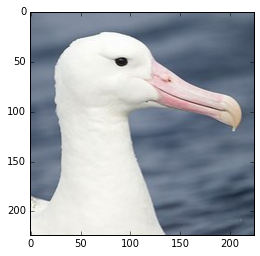

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill
0.000001	pelican
0.000001	American egret
0.000001	oystercatcher
0.000000	ptarmigan


In [21]:
img = imresize(imread('sample_images/albatross.jpg'), (224,224))
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-10:-1]
print 'top-5 classes are:'
for l in labels:
    print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

# Cats Vs Dogs

In [14]:
!wget https://www.dropbox.com/s/2wli3xihvt8a4rx/catdog.tar.gz?dl=1 -O ar.tar.gz
!tar -xvzf ar.tar.gz

--2016-10-23 15:40:24--  https://www.dropbox.com/s/2wli3xihvt8a4rx/catdog.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/LYLLmbHgsg01bqSTmNAksNOwkriHgbcFb7xHp2hm2Bv7aQHU3KwR0ndcywQ5YiG9/file?dl=1 [following]
--2016-10-23 15:40:24--  https://dl.dropboxusercontent.com/content_link/LYLLmbHgsg01bqSTmNAksNOwkriHgbcFb7xHp2hm2Bv7aQHU3KwR0ndcywQ5YiG9/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 45.58.74.37
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|45.58.74.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56265776 (54M) [application/octet-stream]
Saving to: ‘ar.tar.gz’

ar.tar.gz           100%[=====================>]  53.66M  45.8MB/s   in 1.2s   

2016-10-23 15:40:26 (45.8 MB/s) - ‘ar.tar.gz’ saved [56

In [18]:
from tqdm import tqdm
import os
X = []
Y = []
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)

    Y.append(y)
    X.append(prob(preprocess(imresize(img,(224,224)))))

  5%|▍         | 117/2500 [03:53<1:50:44,  2.79s/it]


KeyboardInterrupt: 

# Grand-quest

Основная задача - научиться решать предыдущую задачу(cats vs dogs) гораздо лучше при помощи предобученной сети.

Начать лучше всего с того, что получить выход с одного из полносвязных слоёв (fc6 или fc7) и по нему классифицировать котиков/собачек.

In [32]:
x_features = np.concatenate(X)

#crop if we ended prematurely
Y = Y[:len(x_features)]

In [76]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(x_features,np.array(Y))

In [ ]:
top_classes = np.argsort(np.abs(model.coef_[0]))[::-1]

for i in top_classes:
    print classes[i], model.coef_[0,i]

### TODO:
* Честно посчитать точность предсказания (accuracy, auc) логрегрессии и random forest
* Попытаться подобрать оптимальную модель
* попытаться использовать данные с предпоследнего слоя нейронки вместо последнего


### Если вдруг будет время, про визуализацию vgg

On higher layers, filters have more than 3 channels, so it is impossible to visualize them directly. However, of we want to understand something about features on higher layers, it is possible to visualize them via optimization of the input image.

Namely, we can solve the following problem

$$J=\mathrm{argmax} \left( n^i_{xyc}(I) \right)$$

there $n^i_{xyc}$ is the activation of neuron on $i$'th layer in position $x$,$y$,$c$ given input image $I$.
Basically, $J$ is the answer on a question "what our neuron is looking for?"

In [1]:
generated_image = theano.shared(floatX(np.zeros((1, 3, IMAGE_W, IMAGE_W))))
gen_features = lasagne.layers.get_output(net.values(), generated_image)
gen_features = {k: v for k, v in zip(net.keys(), gen_features)}

layer_name = 'pool1'
c = 0
blob_width = gen_features[layer_name].shape[2]
x = blob_width/2
y = blob_width/2
activation_loss = 1e10*(1e1 - gen_features[layer_name][0, c, x, y])**2

tv_loss = T.mean(T.abs_(generated_image[:,:,1:,1:] - generated_image[:,:,:-1,1:]) +
                 T.abs_(generated_image[:,:,1:,1:] - generated_image[:,:,1:,:-1]))

loss = activation_loss + 1.0 * tv_loss

grad = T.grad(loss, generated_image)

f_loss = theano.function([], loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x_ = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x_)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

NameError: name 'theano' is not defined

In [2]:
#run input image optimization via scipy.optimize.fmin_l_bfgs_b
generated_image.set_value(floatX(np.zeros((1, 3, IMAGE_W, IMAGE_W))))
x0 = generated_image.get_value().astype('float64')
status = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=20)
x0 = generated_image.get_value().astype('float64')

NameError: name 'generated_image' is not defined

If your **deprocess** function is implemented correctly, you'll see that the neuron on the first pooling layer is looking for. The result should look like gabor filter, simular to ones found in the first layer of networks with large filters, such as AlexNet.

In [ ]:
#show the results
w = IMAGE_W
for d in [112, 64, 32, 16, 8]:
    pic = deprocess(x0)[w/2-d:w/2+d,w/2-d:w/2+d,:]
    pic -= pic.min()
    pic /= pic.max()
    plt.imshow(pic, interpolation='None')
    plt.show()

Optional problem:
Adjust the code above to work with neurons on fc8 layer.


fc8 neurons are wired to output classes, so maximization of neuron value will produce an image which contains as much of given class (from the point of view of neural network) as possible. 

Examples of such images are shown at:

http://yosinski.com/deepvis

http://googleresearch.blogspot.ru/2015/06/inceptionism-going-deeper-into-neural.html

http://auduno.com/post/125362849838/visualizing-googlenet-classes

https://317070.github.io/Dream/